In [11]:
# !pip install tavily-python
# !pip install langgraph
# !pip install langgraph-checkpoint-sqlite

In [1]:
import os
from langchain_groq import ChatGroq
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
from langchain_community.vectorstores import FAISS
import faiss
from langchain_community.document_loaders import TextLoader
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts.prompt import PromptTemplate

from dotenv import load_dotenv
from tavily import TavilyClient

_ = load_dotenv()

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List, Dict, Any
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage

memory = SqliteSaver.from_conn_string(":memory:")

## Env set up

In [3]:
os.environ['OPENAI_API_KEY']=os.getenv("OPENAI_API_KEY")
groq_api_key=os.getenv('GROQ_API_KEY')
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

In [4]:
# model_0 = ChatGroq(groq_api_key=groq_api_key,
#              model_name="llama3-groq-70b-8192-tool-use-preview", temperature=0.8)
# model_1 = ChatGroq(groq_api_key=groq_api_key,
#              model_name="llama3-groq-8b-8192-tool-use-preview", temperature=0.3)
# model_2 = ChatGroq(groq_api_key=groq_api_key, 
#                 model_name="llama3-70b-8192", temperature=0.2)
# model_3 = ChatGroq(groq_api_key=groq_api_key,
#                 model_name="llama3-8b-8192", temperature=0.2)


In [5]:
# !pip install sentence_transformers

In [6]:
# Initialize embedding
model_name = "BAAI/bge-small-en"
model_kwargs = {"device": "cpu"} #can also be cpu
encode_kwargs = {"normalize_embeddings": True}
embeddings = HuggingFaceBgeEmbeddings(
            model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
        )

c:\Users\timmy_3aupohg\anaconda3\envs\smog_env\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Rag Database Set up

In [7]:
# loading the text file 
text = TextLoader("hidroelectrica_content.txt")
document = text.load()

In [8]:
# text splitter
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=50)
# initiating the splitter
docs = splitter.split_documents(document)

In [9]:
len(docs)

7359

In [10]:
docs[10].page_content

'de energie electricaLegislatiePrincipii derivate din CEDORegulament CTEModel solicitare acces in obiectiveFormular solicitare sponsorizareGranturiInternshipBurseAvertizor in interes publicAcasaProfilProfil HidroelectricaProfilHidroelectrica este lider in productia de energie electrica si principalul furnizor de servicii tehnologice necesare in Sistemul Energetic National, fiind o companie vitala pentru un sector strategic cu implicatii in siguranta nationala.Infiintata in anul 2000, Hidroelectrica a reusit sa se impuna pe Piata de Energie din Romania datorita experientei, credibilitatii si flexibilitatii sale, fiind in prezent principalul producator si furnizor de energie din Romania cat si principalul furnizor de servicii tehnologice de sistem.Cu o productie in an mediu hidrologic de peste 17 TWh generata in sucursale amplasate strategic pe teritoriul tarii, Hidroelectrica furnizeaza cca. 30% din productia totala a tarii, in functie de hidraulicitatea anului, in timp ce media'

In [11]:
def save_embedded_data(vec_db):
  vec_db.save_local(f"rag_db")
  print("Embeddings saved")

In [14]:
# A function to create vector store
def create_vector_store(embeddings, documents: list):
    # index set up with the embedding dimension
    index = faiss.IndexFlatL2(384)
    # Initialize the FAISS vector store
    vector_store = FAISS(
        embedding_function=embeddings,
        index=index,
        docstore=InMemoryDocstore(),
        index_to_docstore_id={},
    )
    # Now adding other documents to the store. 
    vector_store.add_documents(documents=documents)
        
    # saving the vector store automatically
    save_embedded_data(vector_store)
    
    return vector_store

In [15]:
# using faiss for embedding
vec_db = create_vector_store(embeddings, docs)

Embeddings saved


In [16]:
print(vec_db.index.ntotal)

7359


In [17]:
# saving the vector database
vec_db.save_local("rag_db")

In [18]:
# Loading the vector database
vec_db = FAISS.load_local("rag_db", embeddings, allow_dangerous_deserialization=True)

In [19]:
query = "ProfilDespre noiProfilMisiune"
query_docs = vec_db.similarity_search(query)

In [20]:
query_docs

[Document(metadata={'source': 'hidroelectrica_content.txt'}, page_content='ProfilDespre noiProfilMisiune, viziune si valoriPrezentariPremiiMuzeeConducereStrategieGuvernanta corporativaResponsabilitate SocialaSistem Management IntegratTrofeul EnergeticianuluiEducatie si culturaOameni si pasiuniProiecteContactProducere energieProducere energie electricaDezvoltareFurnizare energieClient CasnicClient BusinessLegislatie Furnizare Energie ElectricaRaportariSucursaleSH BistritaSH ClujSH Curtea de ArgesSH HategSH Portile de FierSH Ramnicu ValceaSH SebesSH Wind ConstantaRelatia cu investitoriiRezultate si rapoarteGuvernanta corporativaAdunarea Generala a ActionarilorDividendeOferta publica de vanzareCalendar si evenimenteContactInformatii de interes publicOferta tip pentru clienti casniciAnunturi publiceCariereAchizitii sectorialeRaportari contracte achizitie publicaIndicatori de performantaLicenteEtichete de energie electricaLegislatiePrincipii derivate din CEDORegulament CTEModel solicitare a

## Agent Set Up

In [70]:
# Define the agent's state
class AgentState(dict):
    query: str
    thoughts: List[str]
    rag_result: str
    tavily_result: str
    response: str

In [71]:
# Router node
def router(state: AgentState) -> str:
    llm = ChatGroq(groq_api_key=groq_api_key,
             model_name="llama3-groq-70b-8192-tool-use-preview", temperature=0)
    prompt = ChatPromptTemplate.from_messages([
        ("system", "Translate the query into english and classify the following query as either 'general_chat', 'company_specific', or 'needs_realtime_info'."),
        ("human", "{query}")
    ])
    response = llm(prompt.format_messages(query=state["query"]))
    classification = response.content.strip().lower()
    
    state["thoughts"].append(f"Query classified as: {classification}")
    
    if "company_specific" in classification:
        return "rag_search"
    elif "needs_realtime_info" in classification:
        return "tavily_search"
    else:
        return "generate_response"

In [72]:
# RAG search node
def rag_search(state: AgentState) -> Dict[str, Any]:
    results = vec_db.similarity_search(state["query"], k=1)
    state["rag_result"] = results[0].page_content
    state["thoughts"].append("Performed RAG search")
    return state

In [73]:
# Tavily search node
def tavily_search(state: AgentState) -> Dict[str, Any]:
    results = tavily.search(query=state["query"], max_results=3)
    state["tavily_result"] = results
    state["thoughts"].append("Performed Tavily search")
    return state

In [74]:
# Decision node
def decide_source(state: AgentState) -> str:
    llm = ChatGroq(groq_api_key=groq_api_key,
             model_name="llama3-groq-70b-8192-tool-use-preview", temperature=0)
    prompt = ChatPromptTemplate.from_messages([
        ("system", "Decide which source(s) to use for answering the query: 'rag', 'tavily', or 'both'."),
        ("human", "Query: {query}\nRAG result: {rag_result}\nTavily result: {tavily_result}")
    ])
    response = llm(prompt.format_messages(
        query=state["query"],
        rag_result=state.get("rag_result", "Not available"),
        tavily_result=state.get("tavily_result", "Not available")
    ))
    decision = response.content.strip().lower()
    
    state["thoughts"].append(f"Decided to use: {decision}")
    return decision

In [75]:
# Generate response node
def generate_response(state: AgentState) -> Dict[str, Any]:
    llm = ChatGroq(groq_api_key=groq_api_key,
             model_name="llama3-groq-70b-8192-tool-use-preview", temperature=0)
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a helpful AI assistant for Hidroelectical. Use the provided information to answer the query accurately."),
        ("human", "Query: {query}\nRAG result: {rag_result}\nTavily result: {tavily_result}")
    ])
    response = llm(prompt.format_messages(
        query=state["query"],
        rag_result=state.get("rag_result", "Not available"),
        tavily_result=state.get("tavily_result", "Not available")
    ))
    state["response"] = response.content
    state["thoughts"].append("Generated response")
    return state

In [76]:
# Critique node
def critique_response(state: AgentState) -> Dict[str, Any]:
    llm = ChatGroq(groq_api_key=groq_api_key,
             model_name="llama3-groq-70b-8192-tool-use-preview", temperature=0)
    prompt = ChatPromptTemplate.from_messages([
        ("system", "Critique the generated response. Ensure it aligns with the user's question and is accurate. If necessary, suggest improvements or request additional Tavily search."),
        ("human", "Query: {query}\nGenerated response: {response}")
    ])
    critique = llm(prompt.format_messages(query=state["query"], response=state["response"]))
    
    if "needs improvement" in critique.content.lower() or "additional search" in critique.content.lower():
        additional_info = tavily.search(query=state["query"], max_results=2)
        state["tavily_result"] = additional_info
        state["thoughts"].append("Performed additional Tavily search based on critique")
        
        # Regenerate response with additional information
        return generate_response(state)
    else:
        state["thoughts"].append("Response passed critique")
        return state

In [80]:
# Create the graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("router", router)
workflow.add_node("rag_search", rag_search)
workflow.add_node("tavily_search", tavily_search)
workflow.add_node("decide_source", decide_source)
workflow.add_node("generate_response", generate_response)
workflow.add_node("critique_response", critique_response)

# Add conditional edges
workflow.set_entry_point("router")
workflow.add_conditional_edges("router", lambda state: state["next_node"], {
    "rag_search": "rag_search",
    "tavily_search": "tavily_search",
    "generate_response": "generate_response"
})
workflow.add_edge("rag_search", "decide_source")
workflow.add_edge("tavily_search", "decide_source")
workflow.add_conditional_edges("decide_source", lambda state: state["next_node"], {
    "rag": "generate_response",
    "tavily": "generate_response",
    "both": "generate_response"
})
workflow.add_edge("generate_response", "critique_response")
workflow.add_edge("critique_response", END)

# Compile the graph
agent = workflow.compile()

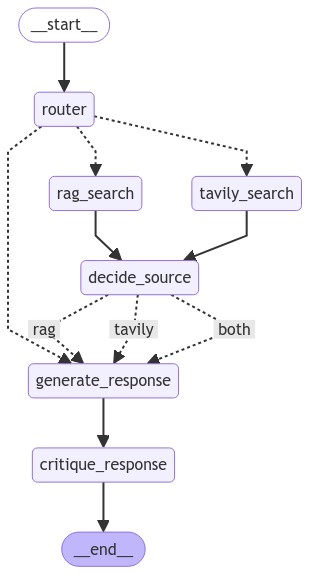

In [81]:
from IPython.display import Image

try:
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [82]:
# Function to run the agent
def run_agent(query: str) -> Dict[str, Any]:
    return agent.invoke({
        "query": query,
        "thoughts": [],
        "rag_result": "",
        "tavily_result": "",
        "response": ""
    })

# Example usage
result = run_agent("What are Hidroelectical's current projects?")
print("Query:", result["query"])
print("Response:", result["response"])
print("Thoughts:", result["thoughts"])

InvalidUpdateError: Expected dict, got rag_search